<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/7.Controller-tuning/Control-Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações iniciais

In [1]:
! pip install -qq control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 6.3 MB/s eta 0:00:00


In [2]:
import numpy as  np
import control as ct
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Definir  modelo do processo

In [3]:
def tanque_nivel(t,x,u):

    '''modelo do tanque com a válvula'''

    # parametros do modelo
    A1, A2 = 5.0, 2.0
    k1, k2 = 7.5, 7.2

    # parametros da válvula
    Fmax = 15
    Fmin = 1
    Kv = (Fmax-Fmin)/100
    tauV = 0.10

    # variáveis de estado
    h1, h2, F2 = x

    # variáveis de entrada
    F1 = u[0]
    p = u[1]

    # equações do modelo
    dh1 = 1/A1*( F1 + F2 -k1*np.sqrt(h1))
    dh2 = 1/A2*( k1*np.sqrt(h1) - k2*np.sqrt(h2))
    dF2 = (-F2 + Kv*p + Fmin)/tauV


    # saida do modelo
    dx = np.array([dh1, dh2, dF2])

    return dx

# Condições iniciais

In [4]:
# condição inicial
xs =  [2.778, 3.014, 7.50] # h1, h2, F2
us =  [5, 46.43] # F1, p

# Identficação do processo

35.3% de Delta_h ->  3.1767388650383888
85.3% de Delta_h ->  3.407247172458203

Processo: Kp = 4.6102e-02  taup = 2.6398  theta = 1.0188


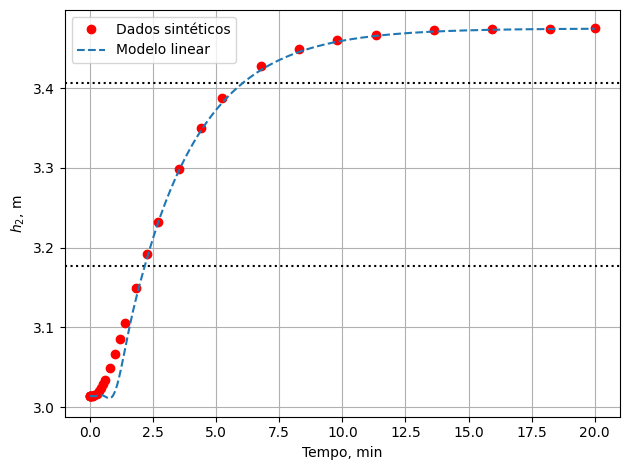

In [21]:
# teste degrau na abertura da válvula para encontrar o modelo linear
u0 = np.copy(us)
delta_p = 10
u0[1] = u0[1] + delta_p

model = lambda t,x: tanque_nivel(t,x,u0)
sol = solve_ivp(model, [0,20], xs, method = 'BDF')

t = sol.t
h2 = sol.y[1].T
plt.plot(t, h2, 'or', label = 'Dados sintéticos')

Delta_h2 = h2[-1] - h2[0]

print('35.3% de Delta_h -> ', xs[1] + 0.353*(Delta_h2))
print('85.3% de Delta_h -> ', xs[1] + 0.853*(Delta_h2))

plt.axhline(y = xs[1] + 0.353*(Delta_h2), linestyle=':', color = 'k')
plt.axhline(y = xs[1] + 0.853*(Delta_h2), linestyle=':', color = 'k')

t1 = 2.14
t2 = 6.08

theta = np.max([0, 1.3*t1 - 0.29*t2 ])
taup = 0.67*(t2-t1)
Kp = Delta_h2/delta_p

print('\nProcesso: Kp = %1.4e  taup = %1.4f  theta = %1.4f' %(Kp, taup, theta))

s = ct.tf('s')
Gp = Kp/(taup*s+1) * ct.tf(* ct.pade(theta, 5,3))
t, y  = ct.step_response(Gp, T = sol.t[-1])
plt.plot(t, delta_p*y + xs[1], '--', label = 'Modelo linear')
plt.legend()
plt.xlabel('Tempo, min')
plt.ylabel(r'$h_2$, m ')
plt.tight_layout()
plt.grid()

# Correlações de sintonia do controlado PI

In [24]:
def sintonia(K, tau, theta, tipo):

    if tipo == 'IMC':
        tauC = tau/3
        Kc = tau/(K*(tauC + theta))
        tauI = tau

    elif tipo == 'ITAEs':
        # ITAE - servo
        Kc = (1/K) *0.586*(theta/tau)**(-0.916)
        tauI = tau/(1.03 - 0.165*(theta/tau))

    elif tipo == 'ITAEr':
        # ITAE - regulador
        Kc = (1/K) *0.859*(theta/tau)**(-0.977)
        tauI = tau/(0.674*(theta/tau)**(-0.680))

    elif tipo == 'ZN':
        s = ct.tf('s')
        Gp = Kp/(tau*s+1) * ct.tf(*ct.pade(theta,10))
        MG, _, wc, _ = ct.margin(Gp)
        Ku = MG
        Pu = 2*np.pi/wc
        Kc = Ku/2.2
        tauI = Pu/1.2
    else:
        print('Tipo errado')

    return Kc, tauI

# Simulação da malha fechada com PI na forma de algoritmo de velocidade

In [25]:
# condição inicial e parametros do processo
xs =  [2.778, 3.014, 7.50] # h1, h2, F2
us =  [5, 46.43] # F1, p

# parametros do modelo linear
Kp = 7.1280e-02;  taup = 2.6398;  theta = 1.0188

# configuração do controlador
tipo = 'ITAEr'
Kc, tauI = sintonia(Kp, taup, theta, tipo)
print(f'Controlador: Kc = {Kc:1.2f} tauI = {tauI:1.2f}')

# configuração do tempo
Ts = 0.50 # 5*taup/10
t_final = 80+Ts
t = np.arange(0,t_final,Ts) # simulação até t_final, com passos Ts
N = len(t)

# váriaveis do sistema de controle
up = us; nu = len(up)  # entradas: [F1, p]
xp = xs; nx = len(xp)  # estados: [h1, h2, F2]
ix = 1 # posição da variável controlada
iu = 1 # posição da variável manipulada
id = 0 # posição da variável perturbação

# setpoint nominal
h_set0 = xs[ix]

# perturbação nominal
F1_0 = us[id]

# alocar variáveis
U = np.zeros((N,nu)); U[0,:] = up
X = np.zeros((N,nx)); X[0,:] = xp
hset = h_set0*np.ones(N)
e = np.zeros(N)

for k in range(1,N):

    # fazer testes aqui
    if t[k] > 10:
        hset[k] = h_set0*(1+0.05) # degrau +5.0%

    if t[k] > 30:
        hset[k] = h_set0*(1-0.075) # degrau -7.5%

    if t[k] > 50:
        up[id] = F1_0 - 0.25 # degrau em F1

    # implementar entradas para coletar dados do processo
    tspan = [t[k-1], t[k]]
    model = lambda t,x: tanque_nivel(t,x,up)
    sol = solve_ivp(model, tspan, xp, method = 'BDF')
    xp = sol.y.T[-1,:]

    # medição da variável controlada
    hm = xp[ix] + 0.00*np.random.randn()

    # calcular ação de controle
    e[k] = hset[k] - hm # erro de controle
    du = Kc*(e[k]-e[k-1] + Ts/tauI * e[k]) # algoritmo de velocidade

    # atualizar informações
    up[iu] = up[iu] + du
    X[k,:] = xp
    U[k,:] = up


Controlador: Kc = 30.55 tauI = 2.05


# Resultados

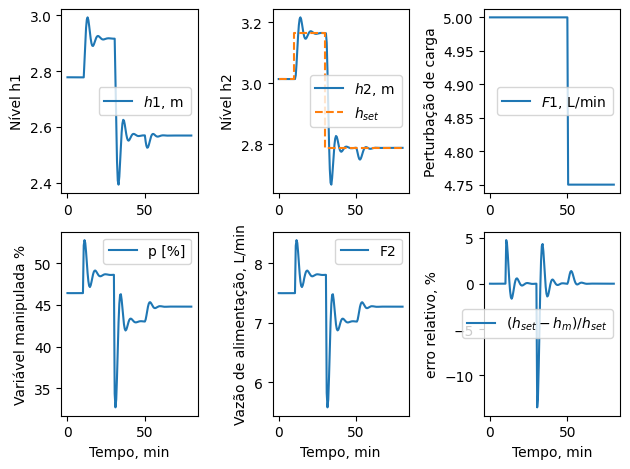

In [26]:
(fig, ([ax1, ax2, ax3], [axp, axF2, axerro])) = plt.subplots(2,3, sharex=False)

ax1.plot(t,X[:,0], label = r'$h1$, m ')
ax1.set_ylabel('Nível h1')
ax1.legend( )

ax2.plot(t,X[:,1], label = r'$h2$, m ')
ax2.step(t,hset,'--', label = r'$h_{set}$')
ax2.set_ylabel('Nível h2')
ax2.legend( )

ax3.plot(t,U[:,id], label = r'$F1$, L/min ' )
ax3.set_ylabel('Perturbação de carga')
ax3.legend( )

axp.plot(t,U[:,iu], label = 'p [%]' )
axp.set_ylabel('Variável manipulada %')
axp.set_xlabel('Tempo, min')
axp.legend( )

axF2.plot(t,X[:,2], label = 'F2')
axF2.set_ylabel('Vazão de alimentação, L/min')
axF2.set_xlabel('Tempo, min')
axF2.legend( )

axerro.plot(t,100*e/hset, label = r'$(h_{set} - h_{m}) / h_{set}$')
axerro.set_ylabel('erro relativo, %')
axerro.set_xlabel('Tempo, min')
axerro.legend( )

plt.tight_layout()
plt.subplots_adjust()